# Testing degradation on ABC vs true distribution

In [3]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

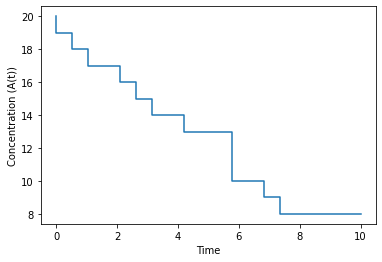

In [5]:
np.random.seed(2)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 20)

values = model.simulate(real_parameters, times)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0], [0.3])

# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('Time')
plt.ylabel('Concentration (A(t))')

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)


plt.savefig(my_path + '/degradation_model.pdf')

# res_kl_adaptive_pmc = resulting_kl

# plt.show()

In [15]:
np.random.seed(0)

from math import comb

n_0 = 20

# Probability for one data point
def compute_prob(n, t, k):
    exp_term = np.exp(-k * n * t)
    comb_term = comb(n_0, int(n)) 
    t_term = (1 - np.exp(-k * t)) 
    return exp_term * comb_term * (t_term ** (n_0 - n))

# Probability for multiple data points
def prob_gen(data, times, k):
    all_prob = 1.0
    for i in range(len(data)):
        computed_prob = compute_prob(data[i][0], times[i], k)
        all_prob *= computed_prob
    return all_prob


# Compute integral
from scipy import integrate

func = lambda x : prob_gen(values, times, x)
int_val = integrate.quad(func, 0.01, 0.3)
print("likelihood integrate value="+str(int_val[0]))

# True posterior
def posterior(data, times, k):
    return prob_gen(data, times, k) / int_val[0]

thetas = np.linspace(0.01, 0.3, 200)
true_prob = []
for i in range(len(thetas)):
    true_prob.append(posterior(values, times, thetas[i]))

v_func = lambda x : posterior(values, times, x)
i_val = integrate.quad(v_func, 0.01, 0.3)

print("posterior integrate value="+str(i_val[0]))

likelihood integrate value=5.086995413811021e-16
posterior integrate value=0.9999392938746746


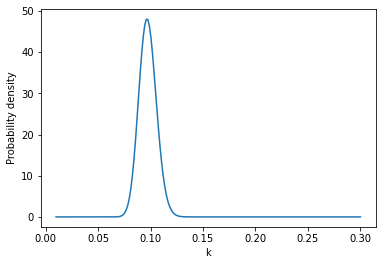

In [7]:
plt.plot(thetas, true_prob)

import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)

plt.ylabel("Probability density")
plt.xlabel("k")
plt.savefig(my_path + '/degradation_posterior.pdf')
# plt.show()

# Rejection ABC

In [115]:
error_thresholds = [7, 5, 3, 2, 1]
resulting_kl = []

np.random.seed(0)
for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior)

        # set threshold
        abc.sampler().set_threshold(error)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        print('Running...')
        samples  = abc.run()
        print('Done')

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[:, 0])

        inter_kl.append(kl_div(t_samples, error * 0.01, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 7
Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     2      0.5              0:00.0
2     3      0.666666667      0:00.0
3     6      0.5              0:00.0
20    25     0.8              0:00.0
40    49     0.816326531      0:00.0
60    72     0.833333333      0:00.1
80    96     0.833333333      0:00.1
100   118    0.847457627      0:00.1
120   139    0.863309352518   0:00.1
140   162    0.864197531      0:00.1
160   187    0.855614973262   0:00.1
180   209    0.861244019      0:00.1
200   231    0.865800866      0:00.2
220   252    0.873015873      0:00.2
240   274    0.875912409      0:00.2
260   295    0.881355932      0:00.2
280   319    0.877742947      0:00.2
300   341    0.879765396      0:00.2
320   367    0.871934605      0:00.2
340   390    0.871794872      0:00.2
360   412    0.873786407767   0:00.3
380   432    0.87962963       0:00.3
400   455    0.879120879      0:00.3
420   475    0.884210526      0:00.3

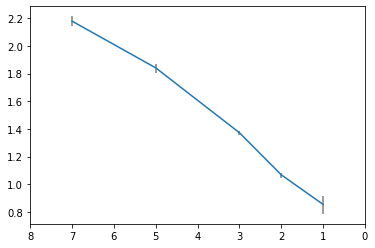

In [116]:
resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


fig, ax = plt.subplots()


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='gray')
plt.xlim(8, 0)

res_kl_abc_rej = resulting_kl

# PMC Degradation (with smc)

In [133]:
error_thresholds = [7, 5, 3, 2, 1]
resulting_kl = []

np.random.seed(0)
for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
        # set initial threshold
        abc.sampler().set_threshold_schedule(np.array([error * 1.5, error * 1.3, error]))

        # produce intermediate distributions of size 1000
        abc.sampler().set_intermediate_size(500)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        samples = abc.run()
        print("Done")

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[:, 0])

        inter_kl.append(kl_div(t_samples, error * 0.01, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 7
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10.5
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.0
2     2      1                0:00.0
3     3      1                0:00.0
20    20     1                0:00.0
40    40     1                0:00.0
60    60     1                0:00.0
80    80     1                0:00.0
100   100    1                0:00.1
120   120    1                0:00.1
140   140    1                0:00.1
160   160    1                0:00.1
180   180    1                0:00.1
200   200    1                0:00.1
220   220    1                0:00.1
240   240    1                0:00.1
260   260    1                0:00.1
280   280    1                0:00.1
300   300    1                0:00.2
320   320    1                0:00.2
340   340    1                0:00.2
360   360    1                0:00.2
380   380    1                0:00.2
400   400    1                0:00.2
420   420    1     

[[2.2453675002308198, 2.252850026155501, 2.194704469312309, 2.2858709049539696, 2.259094618159683], [2.0941742308265217, 2.135320146892426, 2.1335421702032185, 2.179660570556991, 2.1798638418791407], [1.662798971174427, 1.6104338133326108, 1.6872022392122856, 1.6504416068511105, 1.5632872241301778], [1.2695864101718464, 1.2605727023823423, 1.2618581271620712, 1.296118485928378, 1.2695489516212177], [0.904974017376963, 0.8702454569411867, 0.9070854110737574, 0.8955953128190003, 0.9290008282875899]]
[7, 5, 3, 2, 1]


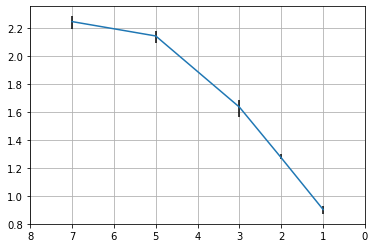

In [134]:
print(resulting_kl)
print(error_thresholds)


resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


fig, ax = plt.subplots()


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='black')
plt.xlim(8, 0)
plt.grid(True)

plt.show()
res_kl_true_pmc_rej = resulting_kl

# ABC SMC

In [130]:
error_thresholds = [7, 5, 3, 2, 1]
resulting_kl = []

np.random.seed(0)
for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
        # set initial threshold
        abc.sampler().set_threshold_schedule(np.array([error * 1.5, error * 1.3, error]))

        # produce intermediate distributions of size 1000
        abc.sampler().set_intermediate_size(200)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        samples = abc.run()
        print("Done")

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[:, 0])

        inter_kl.append(kl_div(t_samples, error * 0.01, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 7
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10.5
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.0
2     2      1                0:00.0
3     3      1                0:00.0
20    20     1                0:00.0
40    40     1                0:00.0
60    60     1                0:00.0
80    80     1                0:00.0
100   100    1                0:00.1
120   120    1                0:00.1
140   140    1                0:00.1
160   160    1                0:00.1
180   180    1                0:00.1
Starting t=1, with threshold=9.1
200   200    1                0:00.1
220   220    1                0:00.1
240   240    1                0:00.1
260   260    1                0:00.2
280   280    1                0:00.2
300   300    1                0:00.2
320   320    1                0:00.2
340   340    1                0:00.3
360   360    1                0:00.3
380   380    1                0:00.3
Starting t=2, with thre

[[2.1563543916586876, 2.187294835990367, 2.2032110511782306, 2.202367308119368, 2.3737965895082582], [1.9615211405969295, 2.0333398091311037, 1.9654195017916416, 2.100387229296522, 2.0469387751583317], [1.4223006974055372, 1.414022700869339, 1.455678399969944, 1.471770690029561, 1.407628384766424], [1.0832275603327055, 1.128855294162097, 1.1125466649307652, 1.0966605165814884, 1.0289605348500874], [0.7597473226939124, 0.8155807654732903, 0.7537703782429719, 0.8072557125258921, 0.8314790203008594]]
[7, 5, 3, 2, 1]


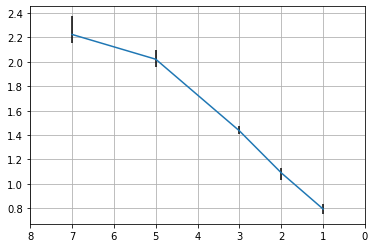

In [131]:
print(resulting_kl)
print(error_thresholds)

resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='black')
plt.xlim(8, 0)
plt.grid(True)

plt.show()
res_kl_fake_pmc_rej = resulting_kl

# Compare all algorithms errors

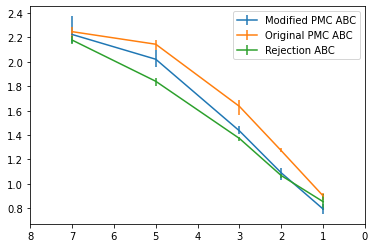

In [132]:

mins_fake_pmc_kl = res_kl_fake_pmc_rej.min(1)
maxes_fake_pmc_kl = res_kl_fake_pmc_rej.max(1)
means_fake_pmc_kl = res_kl_fake_pmc_rej.mean(1)

mins_true_pmc_kl = res_kl_true_pmc_rej.min(1)
maxes_true_pmc_kl = res_kl_true_pmc_rej.max(1)
means_true_pmc_kl = res_kl_true_pmc_rej.mean(1)

mins_abc_rej_kl = res_kl_abc_rej.min(1)
maxes_abc_rej_kl = res_kl_abc_rej.max(1)
means_abc_rej_kl = res_kl_abc_rej.mean(1)

plt.errorbar(error_thresholds, means_fake_pmc_kl, [means_fake_pmc_kl - mins_fake_pmc_kl, maxes_fake_pmc_kl - means_fake_pmc_kl], label='Modified PMC ABC')
plt.errorbar(error_thresholds, means_true_pmc_kl, [means_true_pmc_kl - mins_true_pmc_kl, maxes_true_pmc_kl - means_true_pmc_kl], label='Original PMC ABC')
plt.errorbar(error_thresholds, means_abc_rej_kl, [means_abc_rej_kl - mins_abc_rej_kl, maxes_abc_rej_kl - means_abc_rej_kl], label='Rejection ABC')

plt.xlim(8, 0)
plt.legend()

ax.plot(error_thresholds, res_kl_abc_rej, label='Rejection ABC')
ax.grid(True)
ax.legend()

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/degradation_errors_all.pdf')

# Adaptive PMC ABC

In [118]:
error_thresholds = [0.5, 0.4, 0.3, 0.2]
resulting_kl = []

for error in error_thresholds:
    print("Starting error " + str(error))
    inter_kl = []
    # Perform 5 runs
    for i in range(5):
        abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

        # set threshold
        abc.sampler().set_N_l(300)

        # set p_acc_min
        abc.sampler().set_p_acc_min(error)

        # set target number of samples
        abc.set_n_samples(500)

        # log to screen
        abc.set_log_to_screen(True)

        print('Running...')
        samples  = abc.run()
        print('Done')

        # computing the KDE and KL functions
        def kl_func(y, post, kde_skl):
            part = posterior(values, times, y)
            s_part = np.exp(kde_skl.score_samples([[y]]))
            if s_part == 0 or part == 0:
                return np.inf
            else:
                saved = part * np.log(part / s_part)
                return saved

        def kl_div(x, bandwidth, posterior, **kwargs):
            kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
            kde_skl.fit(x[:, np.newaxis])
            fun = lambda y : kl_func(y, posterior, kde_skl)
            return integrate.quad(fun, 0.01, 0.3)

        def s_posterior(theta):
            return posterior(values, times, theta)

        t_samples = np.array(samples[:, 0])

        inter_kl.append(kl_div(t_samples, 0.1 * error, s_posterior)[0])
    resulting_kl.append(inter_kl)
    print("finished computing kde + "+str(resulting_kl[-1]))

Starting error 0.5
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.13161507]
resulting var=[[0.00825589]]
epsilon=3.5846896657869842
w_mean=[0.11940776]
resulting var=[[0.00481064]]
epsilon=2.8017851452243803
w_mean=[0.11602766]
resulting var=[[0.00443712]]
Iter. Eval. Acceptance rate Time m:s
1     4      125              0:34.0
cnt_sampled=1100
Halting: target number of samples (500) reached.
Done
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.12522337]
resulting var=[[0.00799293]]
epsilon=3.383784863137726
w_mean=[0.11159254]
resulting var=[[0.00357915]]
epsilon=2.7202941017470885
w_mean=[0.11072199]
resulting var=[[0.00259775]]
Iter. Eval. Acceptance rate Time m:s
1     4      125              0:33.9
cnt_sampled=1100
Halting: target number of samples (500) reached.
Done
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.13303714]
resulting var=[[0.00754351]]
epsilon=3.4713109915419564
w_mean=[0.11153766]
resultin

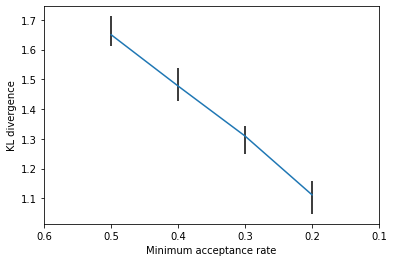

In [121]:
resulting_kl = np.array(resulting_kl)
mins_kl = resulting_kl.min(1)
maxes_kl = resulting_kl.max(1)
means_kl = resulting_kl.mean(1)


# create stacked errorbars:
plt.errorbar(error_thresholds, means_kl, [means_kl - mins_kl, maxes_kl - means_kl], ecolor='black')
plt.xlim(0.6, 0.1)
# plt.grid(True)

# plt.show()


import os

__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

my_path = os.path.abspath(__file)

plt.ylabel("KL divergence")
plt.xlabel("Minimum acceptance rate")
plt.savefig(my_path + '/degradation_errors_adaptive.pdf')

res_kl_adaptive_pmc = resulting_kl